In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

In [3]:
df.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4256,41481,Female,5.0,0,0,No,children,Rural,64.45,21.7,Unknown,0
3509,36298,Female,48.0,0,0,Yes,Self-employed,Rural,71.93,41.7,never smoked,0
3841,13328,Female,45.0,0,0,Yes,Private,Rural,106.95,33.4,Unknown,0
1050,42856,Male,61.0,0,0,Yes,Private,Urban,99.16,26.6,smokes,0
472,2953,Female,43.0,0,0,Yes,Private,Rural,75.05,22.9,smokes,0


In [4]:
df.isna().sum().to_frame(name="Null count")

,Null count
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [5]:
features = ['gender', 'age', 'hypertension', 'heart_disease',
            'ever_married','work_type','Residence_type','avg_glucose_level',
            'bmi','smoking_status']

target = 'stroke'

num_features = ['age', 'avg_glucose_level', 'bmi']

cat_features = ['gender', 'hypertension', 'heart_disease',
                        'ever_married', 'work_type', 'Residence_type', 
                        'smoking_status']

In [6]:
df[num_features] = df[num_features].astype(np.float64)

df[cat_features] = df[cat_features].astype('category')

df.gender.replace({'Other':"Female"}, inplace=True)

df.drop('id', axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, stratify=df.stroke)

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 5)

df_train[num_features] = imputer.fit_transform(df_train[num_features])
df_test[num_features] = imputer.transform(df_test[num_features])

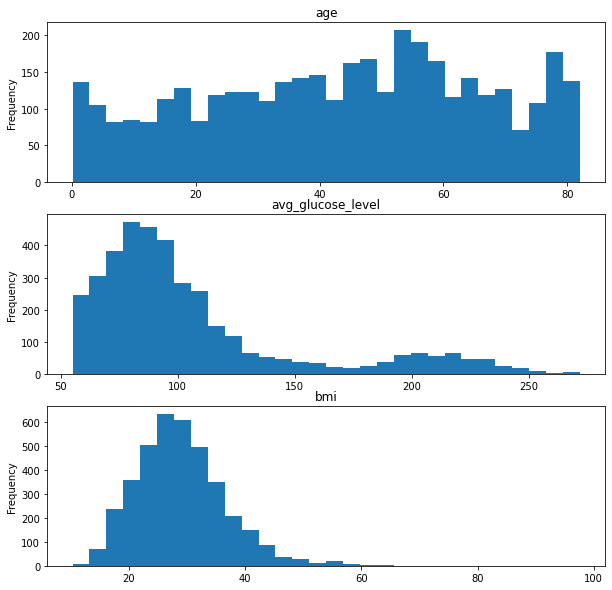

In [9]:
# Histogram Frequency

fig, axes = plt.subplots(nrows=3, figsize=(10,10))
for idx, feature in enumerate(num_features):
    hist = df_train[feature].plot(kind="hist", ax=axes[idx], title=feature, bins=30)

<AxesSubplot:title={'center':'Test Set'}>

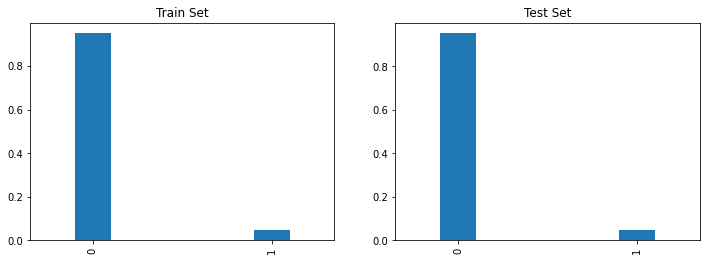

In [10]:
# Target distribution of train and test data set

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

df_train[target].value_counts(normalize=True).plot.bar(width=0.2, ax=axes[0], title="Train Set")

df_test[target].value_counts(normalize=True).plot.bar(width=0.2, ax=axes[1], title="Test Set")

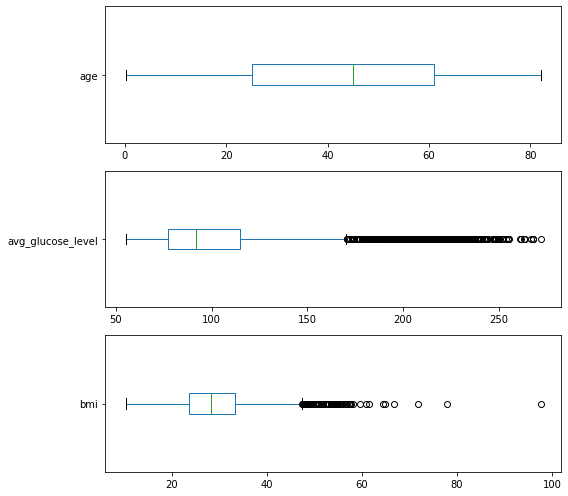

In [11]:
# Boxplot to observe outliers

fig, axes = plt.subplots(nrows=3, figsize=(8, 7))
for idx, feature in enumerate(num_features):
    box = df_train[feature].plot(kind = 'box', ax=axes[idx],
                        vert=False)
plt.tight_layout()
plt.show()

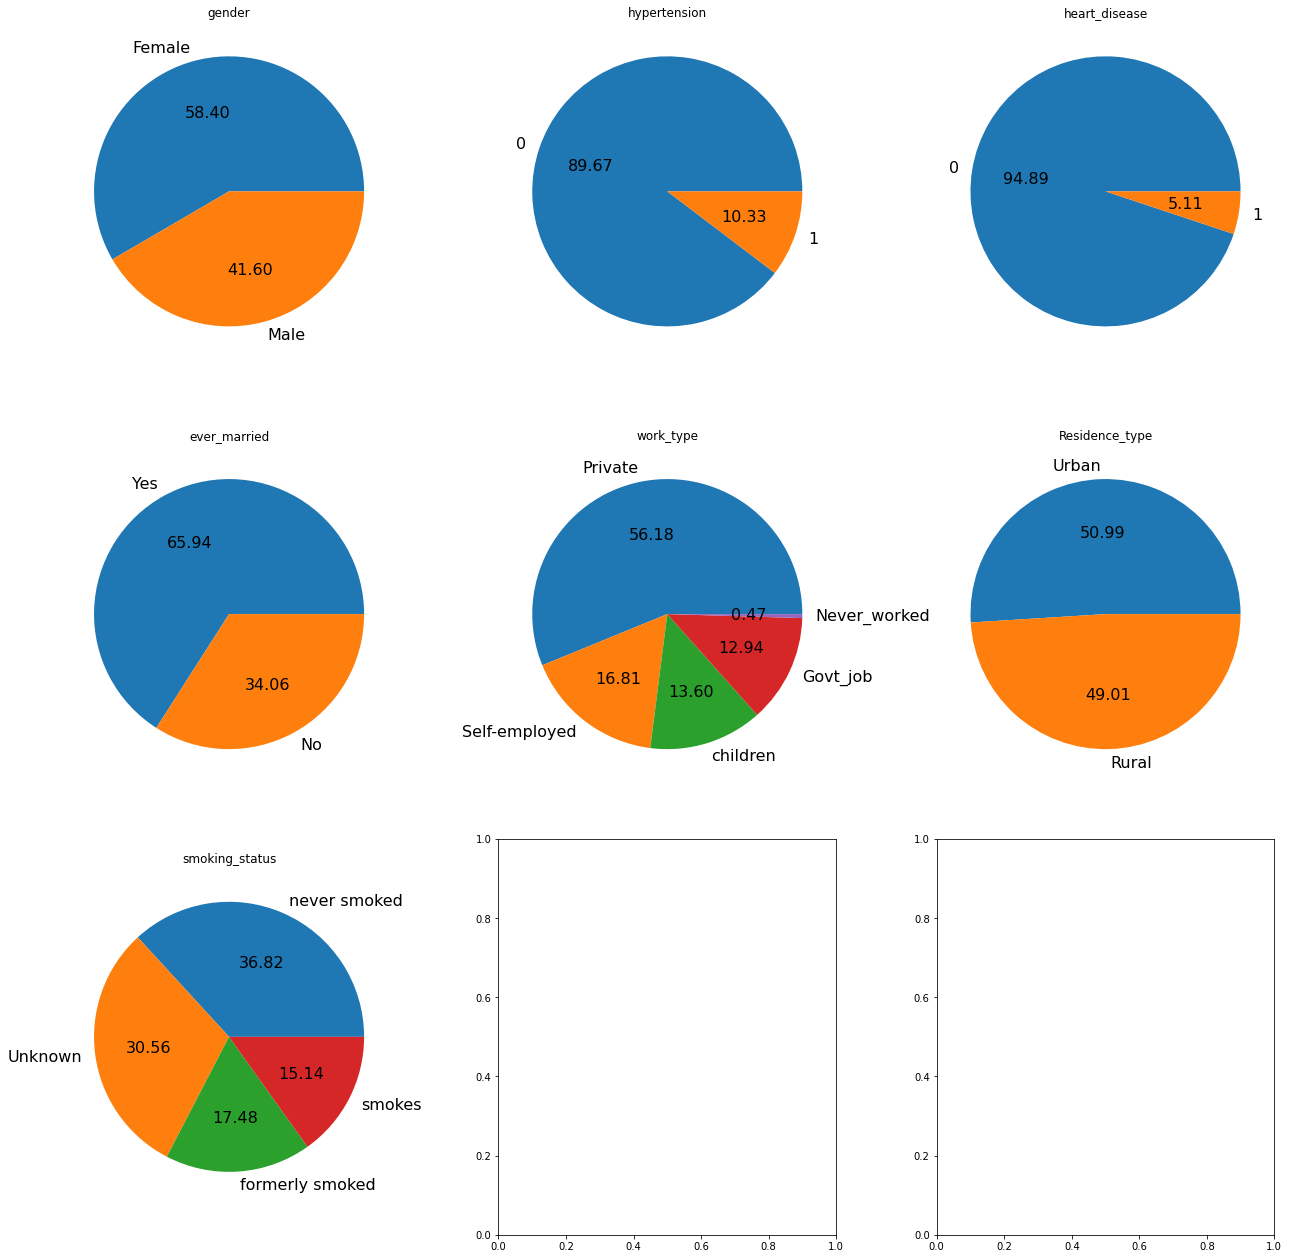

In [12]:
# Pie chart of categorical features

fig, axes = plt.subplots(3, 3, figsize=(18,18))
axes = [ax for axes_row in axes for ax in axes_row]

for idx,feature in enumerate(cat_features):
    df_train[feature].value_counts().plot(kind='pie', ax=axes[idx], title=feature, autopct="%.2f", fontsize=16)
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()

In [13]:
import seaborn as sns
# Bivariate analysis of target vs categorical features

fig, axes = plt.subplots(4, 2, figsize=(12,15))
axes = [ax for axes_row in axes for ax in axes_row]

for idx, feature in enumerate(cat_features):
    df = df_train[[feature,target]].groupby(feature).mean().reset_index()
    sns.barplot(df[feature], df[target], ax=axes[idx])
    axes[idx].set_ylabel('Mean (Target)', fontsize=14)
    axes[idx].set_xlabel(feature, fontsize=14)
    
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [14]:
def categorize_age_group(x):
    if x<13: return "Child"
    elif 13<x<20: return "Teenager"
    elif 20<x<=60: return "Adult"
    else: return "Elder"
    
df_train["age_group"] = df_train.age.apply(categorize_age_group)
df_test['age_group'] = df_test.age.apply(categorize_age_group)

def categorize_bmi_group(x):
    if x<18.5 : return "UnderWeight"
    elif 18.5<x<25: return "Healthy"
    elif 25<x<30: return "OverWeight"
    else: return "Obese"

df_train["bmi_group"] = df_train.bmi.apply(categorize_bmi_group)
df_test['bmi_group'] = df_test.bmi.apply(categorize_bmi_group)

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_features.extend(["age_group", "bmi_group"])

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_train[cat_features])

cols = encoder.get_feature_names(cat_features)

df_train.loc[:, cols] = encoder.transform(df_train[cat_features])
df_test.loc[:, cols] = encoder.transform(df_test[cat_features])

df_train.drop(cat_features, axis=1, inplace=True)
df_test.drop(cat_features, axis=1, inplace=True)

In [16]:
scaler = StandardScaler()
scaler.fit(df_train[num_features])

df_train.loc[:, num_features] = scaler.transform(df_train[num_features])
df_test.loc[:, num_features] = scaler.transform(df_test[num_features])

(22.2, -0.2)

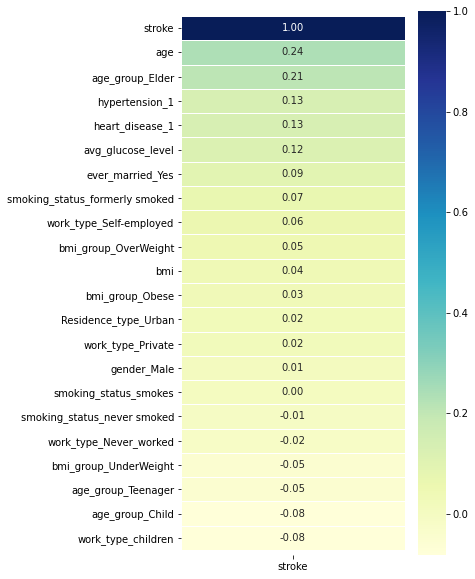

In [17]:
corr_matrix = df_train.corr()[target].sort_values(ascending=False).to_frame()
fig, ax = plt.subplots(figsize=(5,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=.5,fmt=".2f", cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.2, top - 0.2)

In [18]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [19]:


classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
train_preds = classifier.predict(X_train)
test_preds = classifier.predict(X_test)

In [20]:


print("Train f1 Score :", f1_score(y_train, train_preds))
print("Test f1 Score  :", f1_score(y_test, test_preds))

Train f1 Score : 1.0
Test f1 Score  : 0.14173228346456693


In [21]:

# Hyperparameter tuning
params = {
    'max_depth': [4, 7, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30, 40, 50],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128,256],
    'class_weight': [{0: 1, 1: 9}, {0: 1, 1: 4},
                     {0: 1, 1: 7}, {0: 1, 1: 8}]
}

classifier = RandomizedSearchCV(DecisionTreeClassifier(),
                         params,
                         scoring='f1',
                         verbose=1,
                         cv=10,
                         n_iter=100)

search = classifier.fit(X_train, y_train)

print("\nBest f1-score:",search.best_score_)
print("\nBest params:",search.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best f1-score: 0.2788740190913148

Best params: {'min_samples_split': 10, 'max_leaf_nodes': 8, 'max_features': 0.8, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 7}}


In [22]:
classifier = DecisionTreeClassifier(**search.best_params_)

In [23]:
def run_kfold(model, X_train, y_train, N_SPLITS = 10):
    f1_list = []
    oofs = np.zeros(len(X_train))
    folds = StratifiedKFold(n_splits=N_SPLITS)
    for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        print(f'\n------------- Fold {i + 1} -------------')
        X_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model.fit(X_trn, y_trn)

        preds_val = model.predict_proba(X_val)[:,1]

        fold_f1 = f1_score(y_val, preds_val.round())
        f1_list.append(fold_f1)

        print(f'\nf1 score for validation set is {fold_f1}')
        oofs[val_idx] = preds_val

    mean_f1 = sum(f1_list)/N_SPLITS
    print("\n  Mean validation f1 score :", mean_f1)
   
    oofs_score = f1_score(y_train, oofs.round())
    print(f'\nF1 score for out-of-folds : {oofs_score}')
    print("\n            Accuracy score :", model.score(X_test, y_test))

    return oofs

In [24]:
oofs = run_kfold(classifier, X_train, y_train, N_SPLITS=5)


------------- Fold 1 -------------

f1 score for validation set is 0.27777777777777773

------------- Fold 2 -------------

f1 score for validation set is 0.22377622377622378

------------- Fold 3 -------------

f1 score for validation set is 0.208

------------- Fold 4 -------------

f1 score for validation set is 0.3333333333333333

------------- Fold 5 -------------

f1 score for validation set is 0.21428571428571427

  Mean validation f1 score : 0.2514346098346098

F1 score for out-of-folds : 0.25071225071225073

            Accuracy score : 0.8677621283255086


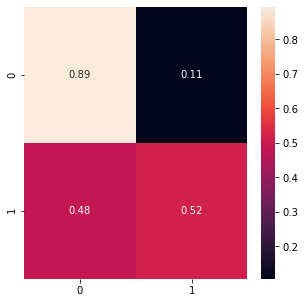

In [25]:
classifier = DecisionTreeClassifier(**search.best_params_)

classifier.fit(X_train, y_train)

preds_test = classifier.predict_proba(X_test)[:, 1]
    
cm = confusion_matrix(y_test,preds_test.round(),normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True,fmt='.2f')
plt.show()

In [26]:
params = {
    'penalty': ['l1', 'l2','elasticnet'],
    'C':[0.0001, 0.001, 0.1, 1, 10, 100,1000],
    'fit_intercept':[True, False],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

classifier = RandomizedSearchCV(LogisticRegression(random_state=1,
                                            class_weight='balanced'),
                         params,
                         scoring='f1',
                         verbose=1,
                         random_state=1,
                         cv=5,
                         n_iter=20)

search = classifier.fit(X_train, y_train)

print("\nBest f1-score:",search.best_score_)
print("\nBest params:",search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best f1-score: 0.21144559723416884

Best params: {'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}


In [27]:
classifier = LogisticRegression(class_weight='balanced', 
                         **search.best_params_)
oofs = run_kfold(classifier, X_train, y_train, N_SPLITS=5)


------------- Fold 1 -------------

f1 score for validation set is 0.2332155477031802

------------- Fold 2 -------------

f1 score for validation set is 0.20149253731343286

------------- Fold 3 -------------

f1 score for validation set is 0.2109090909090909

------------- Fold 4 -------------

f1 score for validation set is 0.24372759856630824

------------- Fold 5 -------------

f1 score for validation set is 0.1678832116788321

  Mean validation f1 score : 0.21144559723416884

F1 score for out-of-folds : 0.21174764321972447

            Accuracy score : 0.7472613458528952


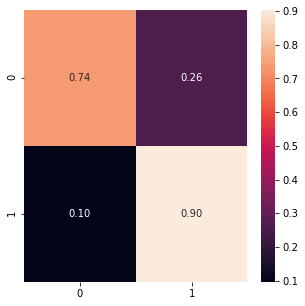

In [28]:
# Final Logistic regression

classifier = LogisticRegression(random_state = 1,
                         class_weight='balanced',
                         **search.best_params_)
classifier.fit(X_train, y_train)

preds_test = classifier.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, preds_test.round(), normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.2f')
plt.show()

In [29]:
with open("model/onehotencoder.pkl", 'wb') as f:
    pickle.dump(encoder, f)

with open("model/scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

with open("model/model.pkl", 'wb') as f:
    pickle.dump(classifier, f)

In [30]:
def predict(x):
    X = pd.DataFrame(x, columns=features)
    # converting numerical features as float dtype
    X.loc[:, num_features] = X.loc[:, num_features].astype('float64')
    # add new features
    X["age_group"] = X.age.apply(categorize_age_group)
    X["bmi_group"] = X.age.apply(categorize_bmi_group)
    
    # converting categorical features as category dtype
    X.loc[:, cat_features] = X.loc[:, cat_features].astype('category')
    # Categorical encoding
    cols = encoder.get_feature_names(cat_features)

    X.loc[:, cols] = encoder.transform(X[cat_features])

    # Drop categorical features
    X.drop(cat_features, axis=1, inplace=True)

    # Feature scaling
    X.loc[:, num_features] = scaler.transform(X[num_features])
    return classifier.predict(X)[0]

In [31]:
# Random data point
x = [['Male', 67.0, 0, 1, 'Yes', 'Private', 'Urban', 228.69, 36.6, 'formerly smoked']]
y_pred = predict(x)

if y_pred:
    print("The patient is likely to have a stroke")
else:
     print("The patient is not likely to have a stroke")

The patient is likely to have a stroke
